 Ensemble Prediction and Decision Tree Model Evaluation

1. Load and Preprocess Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

file_path = "/content/drive/MyDrive/wdbc.data"

# Format: ID, Diagnosis(M=malignant, B=benign), 30 features
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv(file_path, header=None, names=columns)

# Drop ID (not useful for prediction)
df = df.drop("ID", axis=1)

# Encode target labels (M=1 malignant, B=0 benign)
label_encoder = LabelEncoder()
df["Diagnosis"] = label_encoder.fit_transform(df["Diagnosis"])

# Separate features & target
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Dataset loaded and preprocessed successfully!")
print("Shape of X:", X.shape)
print("Class distribution:\n", y.value_counts())

Mounted at /content/drive
✅ Dataset loaded and preprocessed successfully!
Shape of X: (569, 30)
Class distribution:
 Diagnosis
0    357
1    212
Name: count, dtype: int64


2. EDA (Class Balance & Feature Correlation)

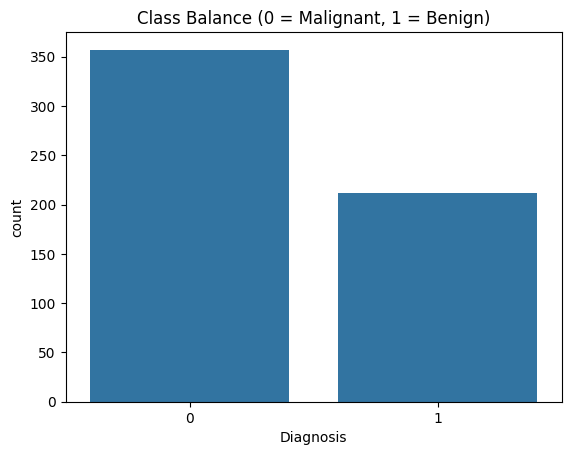

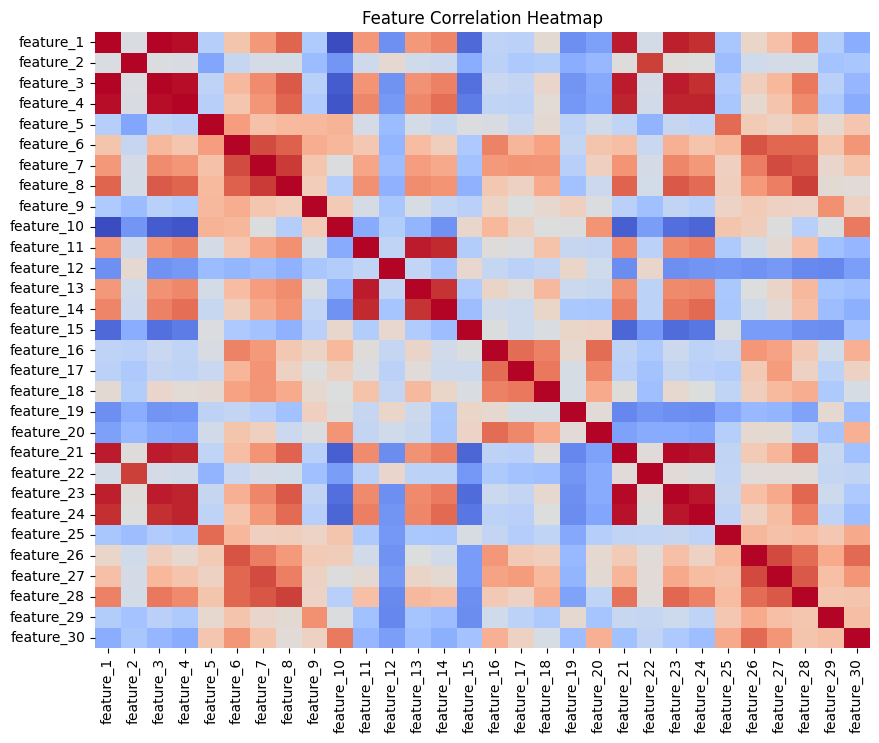

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class balance
sns.countplot(x=y)
plt.title("Class Balance (0 = Malignant, 1 = Benign)")
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()

3. Split Dataset (Train, Validation, Test)

In [4]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42, stratify=y_train_valid)
# 60% train, 20% validation, 20% test

4. Train Models

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, random_state=42)),
            ("nb", GaussianNB()),
            ("dt", DecisionTreeClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

 5. Hyperparameter Tuning with GridSearchCV

In [8]:
param_grids = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "gamma": [0, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "criterion": ["gini", "entropy"],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [2, 5]
    },
    "Stacking": {
        "final_estimator": [LogisticRegression(), RandomForestClassifier(n_estimators=100)]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_valid, y_valid)
    best_models[name] = grid.best_estimator_
    print(f"Best Params: {grid.best_params_}")


🔍 Tuning Decision Tree...
Best Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}

🔍 Tuning AdaBoost...
Best Params: {'learning_rate': 1.0, 'n_estimators': 200}

🔍 Tuning Gradient Boosting...
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

🔍 Tuning XGBoost...
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

🔍 Tuning Random Forest...
Best Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

🔍 Tuning Stacking...
Best Params: {'final_estimator': RandomForestClassifier()}


7. ROC Curves & Metrics on Test Data


Decision Tree | Accuracy: 0.9035, F1: 0.8571, AUC: 0.8750
Confusion Matrix:
 [[70  2]
 [ 9 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        72
           1       0.94      0.79      0.86        42

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114


AdaBoost | Accuracy: 0.9737, F1: 0.9630, AUC: 0.9871
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


Gradient Boosting | Accuracy: 0.9649, F1: 0.9500, AUC: 0.9970
Confusion Matrix:
 [[72  0]
 [ 4 38]]
Classifi

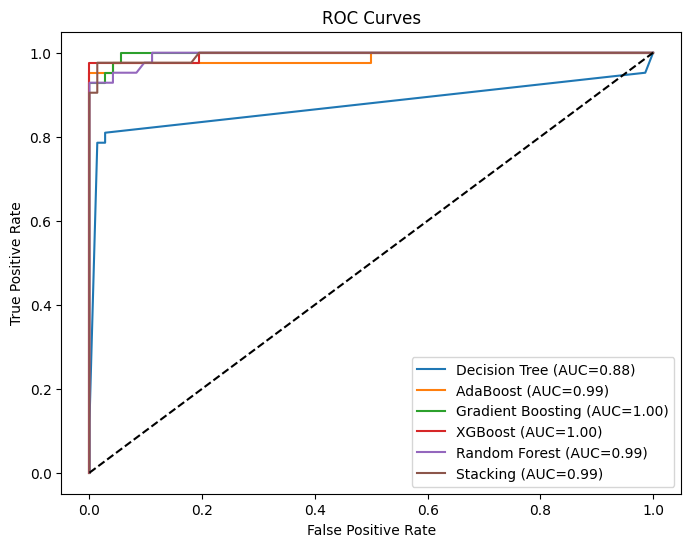

In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

plt.figure(figsize=(8,6))
for name, model in best_models.items():
    model.fit(X_train_valid, y_train_valid)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"\n{name} | Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()